In [ ]:
! mkdir pepper

In [ ]:
! unzip "/content/drive/MyDrive/PEPPER IMAGE SET try 1.zip" -d pepper


Archive:  /content/drive/MyDrive/PEPPER IMAGE SET try 1.zip
   creating: pepper/Resized/
   creating: pepper/Resized/BIG DOT/
  inflating: pepper/Resized/BIG DOT/IMG20210208170109.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210208172638.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210206131635.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210206131514.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210206131511.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210208170645.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210208130354.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210208172806.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210207112458.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210208171735.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210208124945.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210208172408.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210206131002_01.jpg  
  inflating: pepper/Resized/BIG DOT/IMG20210208173940.jpg  
  inflating: pepper/Resized/BIG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi


Thu Feb 11 09:23:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |    355MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 45kB/s 


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/dataset/train'
valid_path = '/content/dataset/val'

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:

# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/dataset/train/*')

In [ ]:
folders

['/content/dataset/train/WHITE PEN',
 '/content/dataset/train/FOLDED',
 '/content/dataset/train/HEALTHY',
 '/content/dataset/train/WILT',
 '/content/dataset/train/BIG DOT',
 '/content/dataset/train/RED DOT',
 '/content/dataset/train/VASOORI']

In [ ]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [ ]:

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

#AUGMENTATION 1


In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

#AUGMENTATION 2


In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=20,
		                              zoom_range=0.15,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.15,
                                  horizontal_flip=True,
                                  fill_mode="nearest")
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/dataset/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1131 images belonging to 7 classes.


In [ ]:
labels = (training_set.class_indices)
print(labels)

{'BIG DOT': 0, 'FOLDED': 1, 'HEALTHY': 2, 'RED DOT': 3, 'VASOORI': 4, 'WHITE PEN': 5, 'WILT': 6}


In [ ]:
test_set = test_datagen.flow_from_directory('/content/dataset/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 139 images belonging to 7 classes.


In [ ]:
labels = (test_set.class_indices)
print(labels)

{'BIG DOT': 0, 'FOLDED': 1, 'HEALTHY': 2, 'RED DOT': 3, 'VASOORI': 4, 'WHITE PEN': 5, 'WILT': 6}


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=7,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
36/36 [==============================] - 17s 396ms/step - loss: 13.6534 - accuracy: 0.2801 - val_loss: 1.7238 - val_accuracy: 0.7050
Epoch 2/7
36/36 [==============================] - 13s 358ms/step - loss: 1.4506 - accuracy: 0.7303 - val_loss: 1.4380 - val_accuracy: 0.7698
Epoch 3/7
36/36 [==============================] - 13s 361ms/step - loss: 0.9704 - accuracy: 0.8224 - val_loss: 1.4150 - val_accuracy: 0.7482
Epoch 4/7
36/36 [==============================] - 13s 359ms/step - loss: 0.8487 - accuracy: 0.8321 - val_loss: 2.2430 - val_accuracy: 0.7338
Epoch 5/7
36/36 [==============================] - 13s 356ms/step - loss: 1.0533 - accuracy: 0.8345 - val_loss: 1.4546 - val_accuracy: 0.8201
Epoch 6/7
36/36 [==============================] - 13s 359ms/step - loss: 0.5485 - accuracy: 0.8713 - val_loss: 1.8356 - val_accuracy: 0.7698
Epoch 7/7
36/36 [==============================] - 13s 357ms/step - loss: 0.8369 - accuracy: 0.8472 - val_loss: 1.4887 - val_accuracy: 0.8417


In [ ]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
36/36 [==============================] - 17s 396ms/step - loss: 10.0220 - accuracy: 0.3192 - val_loss: 1.4679 - val_accuracy: 0.7194
Epoch 2/10
36/36 [==============================] - 13s 360ms/step - loss: 1.6838 - accuracy: 0.7079 - val_loss: 1.1960 - val_accuracy: 0.7698
Epoch 3/10
36/36 [==============================] - 13s 363ms/step - loss: 0.8758 - accuracy: 0.8102 - val_loss: 2.2923 - val_accuracy: 0.6691
Epoch 4/10
36/36 [==============================] - 13s 356ms/step - loss: 0.9991 - accuracy: 0.7879 - val_loss: 1.9686 - val_accuracy: 0.7050
Epoch 5/10
36/36 [==============================] - 13s 355ms/step - loss: 0.9298 - accuracy: 0.8269 - val_loss: 1.6947 - val_accuracy: 0.6978
Epoch 6/10
36/36 [==============================] - 13s 359ms/step - loss: 0.5791 - accuracy: 0.8767 - val_loss: 1.4598 - val_accuracy: 0.7770
Epoch 7/10
36/36 [==============================] - 13s 356ms/step - loss: 0.5949 - accuracy: 0.8798 - val_loss: 1.4968 - val_accuracy: 0.726

In [ ]:
from keras.models import load_model

model.save('/content/drive/MyDrive/Final models/pepper/InceptionV3_Pepper.h5')  

In [ ]:
from keras.models import load_model

model=load_model('/content/drive/MyDrive/Final models/pepper/InceptionV3_Pepper.h5')  

In [ ]:
import os
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
disease= ['BIG DOT', 'FOLDED', 'HEALTHY', 'RED DOT', 'VASOORI', 'WHITE PEN', 'WILT']
import numpy as np
org_disease= ['Pollu disease', 'Thrips', 'HEALTHY', 'Anthracnose', 'Attack of gallfly', 'Scale Insect', 'Quickwilt']
%matplotlib inline
from matplotlib import pyplot as plt

import matplotlib.image as mpimg
#img = mpimg.imread('your_image.png')
dir_path="/content/dataset/test/"
k=0
count=0
for y in range(0, 7):
  print(org_disease[y])
  for i in os.listdir(dir_path+disease[y]):
    k=k+1
    img = image.load_img(dir_path+disease[y]+"/"+i, target_size=(224, 224))
    #imgplot = plt.imshow(img)
    #plt.show()
    # Preprocessing the image
    x = image.img_to_array(img)
    # x = np.true_divide(x, 255)
    ## Scaling
    x=x/255
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    if org_disease[np.argmax(preds)] ==str(org_disease[y]):
      count=count+1
    #print(org_disease[np.argmax(preds)])
  print("total images :"+str(k))
  print("Correctly predicted :"+str(count))
  print(str(float(count/k)*float(100))+ "%") 
  print("")

Pollu disease
total images :25
Correctly predicted :17
68.0%

Thrips
total images :47
Correctly predicted :35
74.46808510638297%

HEALTHY
total images :76
Correctly predicted :57
75.0%

Anthracnose
total images :108
Correctly predicted :84
77.77777777777779%

Attack of gallfly
total images :116
Correctly predicted :90
77.58620689655173%

Scale Insect
total images :135
Correctly predicted :97
71.85185185185186%

Quickwilt
total images :146
Correctly predicted :108
73.97260273972603%



*italicized text*# New SectionEDIT


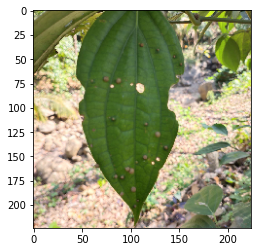

Attack of gallfly


In [ ]:
import numpy as np
import os
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
disease= ['Pollu disease', 'Thrips', 'HEALTHY', 'Anthracnose', 'Attack of gallfly', 'Scale Insect', 'Quickwilt']
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
img = image.load_img("/content/500028400304_505746.jpg", target_size=(224, 224))
imgplot = plt.imshow(img)
plt.show()
x = image.img_to_array(img)

x=x/255
x = np.expand_dims(x, axis=0)
preds = model.predict(x)
print(disease[np.argmax(preds)])
